

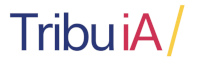


## LLM Multimodal



# Objetivos de hoy

Hoy debemos aprender que significa que un LLM sea multimodal y como podemos usar esa característica para:

* Extraer datos de una Imagen (factura) → **JSON** válido (schema)
* Usar **audio**  para darles instrucciones a un agente (nota de voz) → **INTENT**
* Entender que una **Conversación** puede ser **Multimodal**


#Material de Clase
Repositorio de Github

https://github.com/tribu-ia/don-confiado

Este mismo colab

[https://colab.research.google.com/drive/1KZK_e0BfmGMyOMTYEXv7H-ZWzpM02g90](https://colab.research.google.com/drive/1KZK_e0BfmGMyOMTYEXv7H-ZWzpM02g90)

[https://tinyurl.com/e6ptps2f](https://tinyurl.com/e6ptps2f)



## **Qué es un LLM Multimodal?**


Un LLM multimodal es un modelo de lenguaje avanzado que puede entender, generar y razonar no solo con texto, sino también con otros tipos de datos como imágenes, audio o video. A diferencia de los modelos puramente textuales, un LLM multimodal combina información de diferentes fuentes para dar respuestas más completas y contextualizadas. Por ejemplo, puede analizar una imagen y describirla con palabras, interpretar texto dentro de ella o responder preguntas sobre lo que muestra.


Esta es la misma imagen de la primera clase. Pero os podeís dar cuenta que la conversación puede incluir imagenes, audio o video.   Y el modelo tambien podrá generar texto, imagen, audio o video.


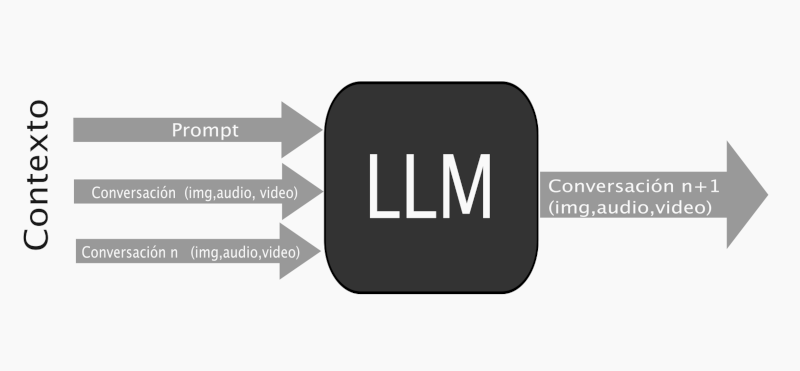




# Son modelos como Sora, Midjourney etc LLM Multimodales?

No debemos confundir un LLM multimodal con los modelos generadores de imagen, video o audio.

También hay modelos especializados en el análisis de multimedia. Estos tampoco son LLM.


# Agenda
* Setup y llaves
* Por qué JSON estructurado para acciones
* Esquemas (Pydantic + JSON Schema)
* Imagen → JSON (demo + ejercicio)
* Audio → Intención (demo + ejercicio)
* Ultimo punto





# *NO MAS TEORIA. VAMOS AL CODIGO*

In [ ]:
print("Instalando dotenv")
!pip install --quiet python-dotenv

print("Instalando openai")
!pip install --quiet openai

print("Instalando genai")
!pip install --quiet google-genai






## Cargamos las llaves 🔑


Ahora vamos a poner las llaves o (API_KEYS) de cada plataforma


Recuerden crear los API KEYS de Google Gemini y OpenAI

Google Gemini:  https://aistudio.google.com/api-keys

OpenAI: https://platform.openai.com/api-keys



In [ ]:
import os
from google.colab import userdata

# Pedir API KEY si no existe como variable de ambiente

userdata_gemini_key = None
try:
  userdata_gemini_key = userdata.get("GEMINI_API_KEY")
except:
  pass


userdata_openai_key = None
try:
  userdata_openai_key = userdata.get("OPENAI_API_KEY")
except:
  pass

print("Para obtener Gemini API Key https://aistudio.google.com/")
if  userdata_gemini_key:
    print("Usando GEMINI_API_KEY de google colab")
    os.environ["GEMINI_API_KEY"] = userdata_gemini_key
elif  "GEMINI_API_KEY" not in os.environ:
    gemini_api_key = input("Por favor, ingrese su API KEY de Gemini: ")
    os.environ["GEMINI_API_KEY"] = gemini_api_key

gemini_api_key = os.getenv("GEMINI_API_KEY")

# Pedir API KEY si no existe como variable de ambiente
if  userdata_openai_key:
    print("Usando OPENAI_API_KEY de google colab")
    os.environ["OPENAI_API_KEY"] = userdata_openai_key
if "OPENAI_API_KEY" not in os.environ:
    openai_api_key = input("Por favor, ingrese su API KEY de OpenAI: ")
    os.environ["OPENAI_API_KEY"] = openai_api_key

openai_api_key = os.getenv("OPENAI_API_KEY")

print("Ya cargaste las llaves en las variables de entorno")
print("Puedes pasar a probar los APIs")


# ** Vamos a enviarle imágenes al LLM**

Vamos a pedirle a los LLM que nos hablen de nuestro querido Estocástico. La mascota de Tribu iA



---



![Descripción de la imagen](https://drive.google.com/uc?export=download&id=1PtMlonMHKPXU17idTlYG6VRk203RwWz0)


#Definimos algunas funciones útiles para procesar archivos


Como necesitamos processar imagenes y audio vamos a crear unas funciones que nos ayudarán a descargarlas desde Internet y extraer sus bytes

In [ ]:
import requests
import os


# Crearemos algunas funciones útiles para manipular las imágenes.


# Necesitamos cargar los bytes de una imágen en un archivo.
def load_image_bytes(path: str) -> bytes:
    with open(path, "rb") as f:
        return f.read()


#Descargamos la imagen y la guardamos localmente
def descargar_archivo(url: str, destino: str):
    """
    Descarga una imagen desde una URL (por ejemplo, de Google Drive o Imgur)
    y la guarda en la ruta especificada.

    Parámetros:
        url (str): URL directa o de descarga del archivo.
        destino (str): Ruta completa donde guardar la imagen, incluyendo el nombre del archivo.
    """
    print(f"📥 Descargando imagen desde: {url}")

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destino, "wb") as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        print(f"✅ Imagen descargada correctamente en: {destino}")
    else:
        raise Exception(f"❌ Error al descargar la imagen: {response.status_code}")

    # Verificar que el archivo existe y tiene contenido
    if not os.path.exists(destino) or os.path.getsize(destino) == 0:
        raise FileNotFoundError("❌ No se encontró la imagen descargada o está vacía.")
    else:
        print(f"📏 Tamaño de imagen: {os.path.getsize(destino)} bytes")

# Ejemplo de uso:
# descargar_imagen("https://drive.google.com/uc?export=download&id=1PMXWYR_hekobCV0jSrFEz5TpIjriU6jM", "/content/imagen_imgur.png")




#Comparemos OpenAI y Gemini


1.   Descargamos la imagen
2.   La convertimos la imagen a base64
3.  Enviamos un mensaje de conversación con la imagen y el texto con lo que queremos que haga el LLM



![Descripción de la imagen](https://drive.google.com/uc?export=download&id=1lCvRAArXFerma13C7QpcTKddlCdjANxN)



# Usos

1. Describir imágenes (la obvia)
2. Preguntar algo sobre la imagen
3. OCR
4. Traductor
5. Extracción de datos
6. Opiniones
7. Resolver ecuaciones, química
8. Convertir a LaTeX, HTML, JSON, Markdown
9. Incluir la imagen como parte de la conversación
10. Cualquier cosa que se les pueda ocurrir

In [ ]:
from google import genai
from openai import OpenAI
import requests
import os
import base64



# URL de la imagen de Imgur

# URL EN COLAB https://drive.google.com/file/d/1PtMlonMHKPXU17idTlYG6VRk203RwWz0/view?usp=drive_link
imgur_url = "https://drive.google.com/uc?export=download&id=1PtMlonMHKPXU17idTlYG6VRk203RwWz0"

# Nombre del archivo local
img_filename = "/content/imagen_imgur.png"

#Descargamos la imagen
descargar_archivo(imgur_url, img_filename)

#Cargamos los bytes de la imagen
img_bytes = load_image_bytes(img_filename)

#Convertimos esos bytes a Base64
imagen_en_base64 = base64.b64encode(img_bytes).decode()




# Inicializar clientes

openai_client = OpenAI(api_key=openai_api_key)

gemini_client = genai.Client(api_key=gemini_api_key)


llm_instruction = """En esta imagen está Estocástico, la mascota de nuestro grupo.
Puedes adivinar por qué se llama así.
"""


# --- GEMINI MULTIMODAL ---
# Instrucción al modelo

gemini_response = gemini_client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[
        {"role": "user", "parts": [
            {"text": llm_instruction},
            {"inline_data": {"mime_type": "image/png", "data":imagen_en_base64}}
        ]}
    ]
)

# --- OPENAI MULTIMODAL ---
openai_response = openai_client.chat.completions.create(
    model="gpt-5-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": llm_instruction},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{imagen_en_base64}"}}
            ]
        }
    ]
)


# --- Resultados ---
print("\n------------------ RESPUESTA GEMINI ------------------")
display(gemini_response.candidates[0].content.parts[0].text)

print("\n------------------ RESPUESTA OPENAI ------------------")
display(openai_response.choices[0].message.content)


In [ ]:
print("------------------GEMINI RESPONSE ---------------")
display(gemini_response)

print("------------------OPENAI RESPONSE ---------------")
display(gemini_response)

## Introducimos Langchain - Multimodal

![image.png](https://drive.google.com/uc?export=download&id=1UbD5tXczZlVJ3xWH6L4eDk4fn-XkfI3V)



Se puede hacer lo mismo con LANGCHAIN. Y a partir de ahora usaremos solo langchain por estandarización.



In [ ]:
!pip install --quiet langchain
!pip install --quiet langchain_google_genai
!pip install --quiet langchain_openai
print("Langchain instalado")


In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage , AIMessage


openai_model = init_chat_model("gpt-4.1-mini",      model_provider="openai",        api_key=openai_api_key)
print("OPENAI_MODEL IS ",type(openai_model))

gemini_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai",  api_key=gemini_api_key)
print("GEMINI_MODEL IS ",type(gemini_model))


human_message = HumanMessage(content=[
        {"type": "text", "text": llm_instruction},
        {"type": "image_url", "image_url": {"url": "data:image/png;base64,"+imagen_en_base64}}

    ])

#Creamos la conversación. Y le ponemos este único mensaje
messages = [
    human_message
]


openai_model_response = openai_model.invoke(messages)
gemini_model_response = gemini_model.invoke(messages)

print("------------------OPENAI RESPONSE ---------------")
print(openai_model_response.content)
print("-----------------------------------------------")
display(openai_model_response)

print("------------------GEMINI RESPONSE ---------------")
print(gemini_model_response.content)
print("-----------------------------------------------")
display(gemini_model_response)



## Structured Output - Multimodal

Se puede hacer con las imágenes, audio y video lo mismo que se hizo en la clase pasada con el texto: **Forzar a que la salida tenga un formato predefinido en JSON**



![image.png](https://drive.google.com/uc?export=download&id=1E-7XLSmxtdvgrK4ebeWREITd-MVxBX_k)



# Lo Primero: definir el objeto de salida. JSON SCHEMA

In [ ]:
from typing import List, Optional
from pydantic import BaseModel, Field


class Emisor(BaseModel):
    """Representa al emisor de la factura."""

    razonSocial: str = Field(
        ...,
        description="Nombre o razón social de la empresa o persona que emite la factura."
    )
    nit: str = Field(
        ...,
        description="Número de identificación tributaria (NIT) del emisor, sin dígito de verificación."
    )

    model_config = {
        "title": "Emisor",
        "description": "Entidad o persona responsable de emitir la factura."
    }


class Item(BaseModel):
    """Detalle de un producto o servicio dentro de la factura."""

    descripcion: str = Field(
        ...,
        description="Descripción detallada del producto o servicio facturado."
    )
    cantidad: float = Field(
        ...,
        description="Cantidad de unidades del producto o servicio."
    )
    precioUnitario: Optional[float] = Field(
        None,
        description="Precio unitario del producto o servicio, antes de impuestos o descuentos."
    )
    subtotal: Optional[float] = Field(
        None,
        description="Subtotal del ítem (cantidad × precioUnitario)."
    )

    model_config = {
        "title": "Item de factura",
        "description": "Elemento que describe un producto o servicio incluido en la factura."
    }


class FacturaColombiana(BaseModel):
    """Modelo estructurado de una factura colombiana estándar."""

    numeroFactura: str = Field(
        ...,
        description="Número único de la factura, por ejemplo 'FV-102223'."
    )
    fechaEmision: str = Field(
        ...,
        description="Fecha de emisión de la factura en formato ISO 8601 (YYYY-MM-DD)."
    )
    moneda: str = Field(
        "COP",
        description="Código de moneda en formato ISO 4217. Por defecto 'COP' para pesos colombianos."
    )
    total: float = Field(
        ...,
        description="Valor total de la factura en la moneda especificada."
    )
    emisor: Emisor = Field(
        ...,
        description="Información del emisor de la factura, incluyendo razón social y NIT."
    )
    items: List[Item] = Field(
        default_factory=list,
        description="Lista de ítems o conceptos facturados, cada uno con su descripción, cantidad y valores."
    )

    model_config = {
        "title": "FacturaColombiana",
        "description": "Representa una factura de venta emitida en Colombia conforme a la normativa local, incluyendo información del emisor, ítems facturados y total."
    }


# Langchain Structured Ouput

Hacemos lo mismo de la clase pasada. Tan solo necesitamos incluir una imagen
en la conversación.

El resultado será un objeto tal cual lo definimos en el paso anterior.

In [ ]:




##img_url = "https://drive.google.com/file/d/1Bnd3d1wAHpYED9vIzvHh6Mt1qpHl3ztY/view?usp=drive_link"
##https://drive.google.com/file/d/1_cnViHMy1eTh0nvVbOOi2J0rvGHKuik8/view?usp=drive_link

img_url = "https://drive.google.com/uc?export=download&id=1_cnViHMy1eTh0nvVbOOi2J0rvGHKuik8"
image_filename = "/content/factura.png"
descargar_archivo(img_url, image_filename)

img_bytes = load_image_bytes(image_filename)
imagen_en_base64 = base64.b64encode(img_bytes).decode()


model_with_structure = gemini_model.with_structured_output(FacturaColombiana)
llm_instruction = "Analizar la imagen y convertir en JSON de factura"
human_message = HumanMessage(content=[
        {"type": "text", "text": llm_instruction},
        {"type": "image_url", "image_url": {"url": "data:image/png;base64,"+imagen_en_base64}}

    ])

#Creamos la conversación. Y le ponemos este único mensaje
messages = [
    human_message
]


response = model_with_structure.invoke(messages)

print("------------------RESPONSE ---------------")
print(type(response))
print(response)
print("-----------------------------------------------")

print(response.model_dump_json(indent=2))


display(response)



## VOZ


Para este Colab necesitamos poder grabar el audio.  Permítanle a su navegador
el acceso al micrófono.  Graben un audio de 20 segundos.




In [ ]:
from IPython.display import Javascript, display
from google.colab import output
import io
import base64

def record_audio(filename='audio.wav', duration=20):
    js_code = f"""
    const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {{
      const reader = new FileReader()
      reader.onloadend = () => resolve(reader.result.split(',')[1])
      reader.readAsDataURL(blob)
    }})

    async function record(duration) {{
      const stream = await navigator.mediaDevices.getUserMedia({{audio:true}})
      const recorder = new MediaRecorder(stream)
      let data = []
      recorder.ondataavailable = e => data.push(e.data)
      recorder.start()

      await sleep(duration * 1000)
      recorder.stop()

      await new Promise(resolve => recorder.onstop = resolve)
      const blob = new Blob(data, {{ type: 'audio/wav' }})
      const base64 = await b2text(blob)
      return base64
    }}

    record({duration}).then(base64 => {{
      google.colab.kernel.invokeFunction('notebook.save_audio', [base64], {{}});
    }})
    """

    # Define Python callback to receive audio data
    def save_audio(base64_audio):
        audio_bytes = base64.b64decode(base64_audio)
        with open(f'/content/{filename}', 'wb') as f:
            f.write(audio_bytes)
        print(f"✅ Audio saved as /content/{filename}")

    output.register_callback('notebook.save_audio', save_audio)
    display(Javascript(js_code))



# GRABA UN MENSAJE


Pídele al agente crear un producto o un proveedor y dale los datos.

In [ ]:
# Example usage: record 10 seconds of audio
record_audio('audio_intention.wav', duration=10)


#Definimos los objetos (JSON SCHEMA)

Defimos que es un UserIntention y los diferentes Payload



In [ ]:
from typing import Optional, List, Literal, Any, Dict
from pydantic import BaseModel, Field

class PayloadCreateProvider(BaseModel):
    nombre: Optional[str] = None
    nit: Optional[str] = None
    direccion: Optional[str] = None
    telefono: Optional[str] = None

class PayloadCreateProduct(BaseModel):
    nombre: str = Field(..., description="Nombre del producto")
    descripcion: str = Field(..., description="Descripción del producto")
    precio: float = Field(..., description="Precio del producto")

class PayloadCreateClient(BaseModel):
    nombre: str = Field(..., description="Nombre del cliente")
    nit: str = Field(..., description="NIT del cliente")
    direccion: str = Field(..., description="Dirección del cliente")



class UserIntention(BaseModel):
    """
    Modelo de salida estructurada: intención + payload correspondiente.
    """
    userintention: Literal["create_provider", "create_client", "create_product", "none", "bye"]
    payload_provider: Optional[PayloadCreateProvider] = None
    payload_client: Optional[PayloadCreateClient] = None
    payload_product: Optional[PayloadCreateProduct] = None
    audio_transcription: Optional[str] = None


# Le enviamos el structured Output y el audio al LLM


![image.png](https://drive.google.com/uc?export=download&id=11DkDft9qkq5nxK6WFjkBKQCpVDdLMf94)



In [ ]:
from typing import Optional, List, Literal, Any, Dict
from pydantic import BaseModel, Field


audio_filename = "/content/audio_intention.wav"


audio_bytes = load_image_bytes(audio_filename)
audio_en_base64 = base64.b64encode(audio_bytes).decode()



model_with_structure = gemini_model.with_structured_output(UserIntention)

llm_instruction = """Eres un asistente de voz para gestión comercial.
    Clasifica la intención del usuario y extrae los datos mencionados según el schema.
    Genera la transcion del audio
    Intenciones: create_provider, create_client, create_product, none, bye."""


human_message = HumanMessage(content=[
        {"type": "text", "text": llm_instruction},
        {
            "type": "audio",
            "source_type": "base64",
            "data": audio_en_base64,
            "mime_type": "audio/wav",        }

    ])

messages = [
    human_message
]


response = model_with_structure.invoke(messages)

print("------------------RESPONSE ---------------")
print(type(response))
print(response)
print("-----------------------------------------------")

print(response.model_dump_json(indent=2))


display(response)

print("✓ Audio extraction logic adjusted for text input (speech-to-text needed)")

# Ahora vamos manderle audio e imagen al LLM

Graba tu audio

In [ ]:
# Example usage: record 10 seconds of audio

print("Inicia la grabación de audio")

record_audio('audio_instruction.wav', duration=20)

Audio and Image

In [ ]:


class UserImageInstruction(BaseModel):
  image_content: Optional[str] = None
  audio_transcription: Optional[str] = None


audio_filename = "/content/audio_instruction.wav"
audio_bytes = load_image_bytes(audio_filename)
audio_en_base64 = base64.b64encode(audio_bytes).decode()

image_filename = "/content/factura.png"
image_bytes = load_image_bytes(image_filename)
image_en_base64 = base64.b64encode(image_bytes).decode()



model_with_structure = gemini_model.with_structured_output(UserIntention)

llm_instruction = """
        "Eres un asistente de voz para gestión comercial.\n"
        "Escucha el audio (comando) y analiza la imagen (p.ej. factura). "
        "Clasifica la intención (create_provider, create_client, create_product, none, bye) "
        "y extrae los datos mencionados según el schema. "
        "realiza la transcripción, inclúyela en 'audio_transcription'."
    """


human_message = HumanMessage(content=[
        # {"type": "text", "text": llm_instruction},
        {
            "type": "audio",
            "source_type": "base64",
            "data": audio_en_base64,
            "mime_type": "audio/wav",        },
        {"type": "image_url", "image_url": {"url": "data:image/png;base64,"+imagen_en_base64}}
    ])

messages = [
    human_message
]


response = model_with_structure.invoke(messages)

print("------------------RESPONSE ---------------")
print(type(response))
print(response)
print("-----------------------------------------------")

print(response.model_dump_json(indent=2))


display(response)

print("✓ Audio extraction logic adjusted for text input (speech-to-text needed)")





## CONVERSACION

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage , AIMessage


img_url = "https://drive.google.com/uc?export=download&id=1_cnViHMy1eTh0nvVbOOi2J0rvGHKuik8"
image_filename = "/content/factura.png"
descargar_archivo(img_url, image_filename)

img_bytes = load_image_bytes(image_filename)
imagen_en_base64 = base64.b64encode(img_bytes).decode()

human_message = HumanMessage(content=[
        {"type": "text", "text": "Te mando una imagen"},
        {"type": "image_url", "image_url": {"url": "data:image/png;base64,"+imagen_en_base64}}
]
)

messages = [
    SystemMessage(content="""Eres Brayan David, un asistente de la Tienda Don Confiado.
    Don Confiado es una tienda de abarrotes en la ciudad de Envigado, Colombia.
    Tienes muchos productos de comida chatarra de productores como Frito Lay, productos Postobón
     Responderás todas las preguntas que te haga tu jefe. """),

    HumanMessage(content="Buenos días. Como te llamas?"),
    AIMessage(content="'¡Buenos días, jefe! Mi nombre es Brayan David, y soy el asistente aquí en la Tienda Don Confiado. ¿En qué puedo ayudarle hoy?"),
    human_message,
    AIMessage(content="He recibido tu imagen"),



    HumanMessage(content="Dime quien emitió la factura")
]

response = gemini_model.invoke( messages)

print(response.content)